# TFM Alba Rodríguez Ceballos - DNI: 70920432R

#### Título: Análisis predictivo de precios de criptomonedas utilizando redes neuronales recurrentes

## Librerías

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM
from keras import optimizers 

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Selección de parámetros


#### La siguiente celda es la única a lo largo de todo el cuaderno que deberá modificarse según la criptomoneda y el modelo deseados.

Las opciónes disponibles para el modelo son las siguientes:
* LSTM
* GRU
* LSTMGRU

Las opciónes disponibles para el modelo son las siguientes:
* SYS
* XLM
* XRP

In [321]:
model = 'LSTMGRU'
cripto = 'XRP'

## Lectura de datos y análisis exploratorio

##### Lectura de los datos en un DataFrame de pandas. 
Importante: Los datasets deben de ser colocados en la misma ruta que el cuaderno.

In [322]:
dataraw = pd.read_csv('data'+cripto+'.csv',index_col='Date', parse_dates=['Date']).sort_values('Date')
dataraw

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2014-12-31,0.024438,0.024455,0.024205,0.024384,5.622160e+05,7.537143e+08
2015-01-01,0.024390,0.024423,0.024309,0.024323,3.900928e+05,7.545424e+08
2015-01-02,0.024318,0.024318,0.022181,0.022181,1.230739e+06,7.274643e+08
2015-01-03,0.022106,0.022142,0.018828,0.018930,3.211723e+06,6.302048e+08
2015-01-04,0.018928,0.020314,0.018890,0.020305,3.473846e+06,6.032247e+08
...,...,...,...,...,...,...
2022-08-25,0.349162,0.368554,0.333530,0.337303,1.373683e+09,1.600905e+10
2022-08-26,0.338526,0.338889,0.330337,0.335478,1.624555e+09,1.546358e+10
2022-08-27,0.335117,0.336616,0.323496,0.323496,7.711837e+08,1.541577e+10


##### Descripción estadística de los datos

In [323]:
dataraw.describe()

,Open,High,Low,Close,Volume,Market Cap
count,2799.000000,2799.000000,2799.000000,2799.000000,2.799000e+03,2.799000e+03
mean,0.352962,0.369179,0.336412,0.352963,2.597665e+09,1.500498e+10
std,0.389135,0.418754,0.362496,0.388698,6.586728e+09,1.638983e+10
min,0.004090,0.004189,0.004041,0.004090,3.428607e+04,1.373416e+08
25%,0.009061,0.009254,0.008836,0.009067,2.059914e+06,3.054259e+08
50%,0.264732,0.275975,0.255666,0.264444,6.210909e+08,1.112545e+10
75%,0.473924,0.491528,0.457287,0.472776,2.060581e+09,1.944027e+10
max,3.357564,3.917855,3.076936,3.359538,1.069988e+11,1.373512e+11


##### Representación gráfica de las variables 'Date' y 'Close'.

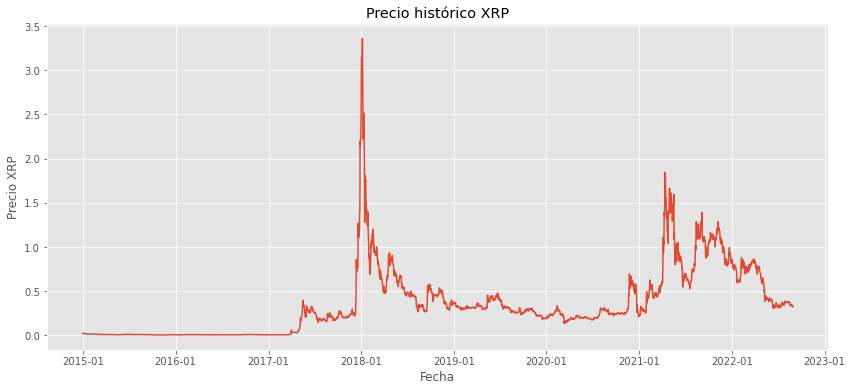

In [324]:
dataset = pd.DataFrame(dataraw['Close'])

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Fecha')
plt.ylabel('Precio ' + cripto)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Precio histórico ' + cripto)
plt.show()

## Preprocesamiento de datos

##### Normalización de los datos máximo-mínimo

In [325]:
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2014-12-31,0.006048
2015-01-01,0.006030
2015-01-02,0.005391
2015-01-03,0.004423
2015-01-04,0.004832
...,...
2022-08-25,0.099305
2022-08-26,0.098761
2022-08-27,0.095190


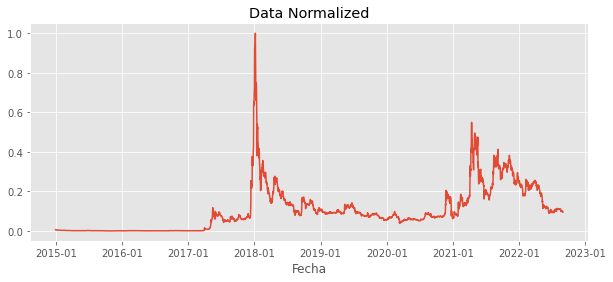

In [326]:
fig = plt.figure(figsize=(10, 4))
plt.plot(dataset_norm)
plt.xlabel('Fecha')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

##### Data Split
Entrenamiento (70%) - Validación (10%) - Test (20%)

In [327]:
#Particiones
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

#Almacenar particiones en dataframes
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

Visualización de la partición

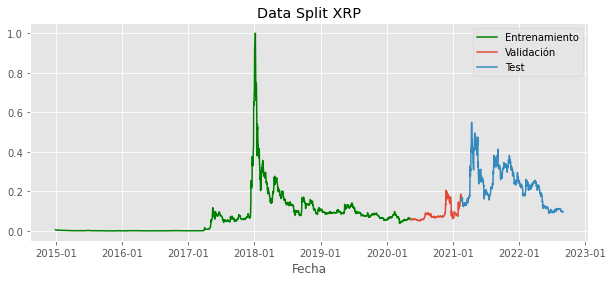

In [328]:
fig = plt.figure(figsize=(10, 4))
plt.plot(training_set, color='green',label='Entrenamiento')
plt.plot(val_set, label='Validación')
plt.plot(test_set, label='Test')
plt.xlabel('Fecha')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Split ' + cripto)
plt.legend()
plt.show()

##### Creación de la sliding window

In [329]:
# tamaño de la ventana
lag = 2

# función para crear la sliding window sobre cada partición
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formatear los datos en arrays para poder crear la sliding window
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Crear sliding windows sobre los datos de entrenamiento
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Crear sliding windows sobre los datos de validacion
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))

# Crear sliding windows sobre los datos de test
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

## Implementación de los modelos

##### Definición de los modelos

LSTM

In [330]:
def modelo_LSTM():

    regressorLSTM = Sequential()


    # Primera capa LSTM con dropout del 20%
    regressorLSTM.add(LSTM(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'tanh'))
    regressorLSTM.add(Dropout(0.2))
    
    # Segunda capa LSTM con dropout del 20%
    regressorLSTM.add(LSTM(units=hidden_unit, return_sequences=False))
    regressorLSTM.add(Dropout(0.2))

    # Capa de salida fully-connected
    regressorLSTM.add(Dense(units=1))

    # Compilado del modelo
    regressorLSTM.compile(optimizer=tf.optimizers.Adam(learning_rate),loss='mean_squared_error')

    # Ajustado del modelo a los datos de entrenamiento
    pred = regressorLSTM.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)
    
    return pred, regressorLSTM

GRU

In [331]:
def modelo_GRU():

    regressorGRU = Sequential()

    # Primera capa GRU con dropout del 20%
    regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'tanh'))
    regressorGRU.add(Dropout(0.2))
    
    
    # Segunda capa GRU con dropout del 20%
    regressorGRU.add(GRU(units=hidden_unit, return_sequences=False))
    regressorGRU.add(Dropout(0.2))

    # Capa de salida fully-connected
    regressorGRU.add(Dense(units=1))

    # Compilado del modelo
    regressorGRU.compile(optimizer=tf.optimizers.Adam(learning_rate),loss='mean_squared_error')

    # Ajustado del modelo a los datos de entrenamiento
    pred = regressorGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)
    
    return pred, regressorGRU

LSTM-GRU

In [332]:
def modelo_LSTMGRU():

    regressorLSTMGRU = Sequential()
    
    # Primera capa LSTM con dropout del 20%
    regressorLSTMGRU.add(LSTM(hidden_unit,return_sequences=True,input_shape=(x_train.shape[1],1), activation = 'tanh'))
    regressorLSTMGRU.add(Dropout(0.2))
    
    # Segunda capa GRU con dropout del 20%
    regressorLSTMGRU.add(GRU(units=hidden_unit, return_sequences=False))
    regressorLSTMGRU.add(Dropout(0.2))

    # Capa de salida fully-connected
    regressorLSTMGRU.add(Dense(units=1))

    # Compiling the Gated Recurrent Unit
    regressorLSTMGRU.compile(optimizer=tf.optimizers.Adam(learning_rate),loss='mean_squared_error')

    # Fitting ke data training dan data validation
    pred = regressorLSTMGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)
    
    return pred, regressorLSTMGRU

##### Ejecución del modelo elegido y la selección de los hiperparámetros correspondientes

In [333]:
if model == 'LSTM':
    
    #Hiperparámetros
    learning_rate = 0.001
    hidden_unit = 80
    batch_size = 64
    epoch = 60
    
    #Ejecución
    pred, regresor = modelo_LSTM()
    
if model == 'GRU':
    
    #Hiperparámetros
    learning_rate = 0.001
    hidden_unit = 60
    batch_size = 64
    epoch = 80
    
    #Ejecución
    pred, regresor = modelo_GRU()
    
if model == 'LSTMGRU':
    
    #Hiperparámetros
    learning_rate = 0.001
    hidden_unit = 60
    batch_siz = 64
    epoch = 80
    
    #Ejecución
    pred, regresor = modelo_LSTMGRU()
    

Epoch 1/80
31/31 [==============================] - 7s 47ms/step - loss: 0.0066 - val_loss: 3.4129e-04
Epoch 2/80
31/31 [==============================] - 0s 10ms/step - loss: 7.9823e-04 - val_loss: 1.1898e-04
Epoch 3/80
31/31 [==============================] - 0s 11ms/step - loss: 4.5386e-04 - val_loss: 1.1982e-04
Epoch 4/80
31/31 [==============================] - 0s 10ms/step - loss: 4.4917e-04 - val_loss: 1.1461e-04
Epoch 5/80
31/31 [==============================] - 0s 11ms/step - loss: 4.6048e-04 - val_loss: 1.1780e-04
Epoch 6/80
31/31 [==============================] - 0s 11ms/step - loss: 4.4262e-04 - val_loss: 1.3255e-04
Epoch 7/80
31/31 [==============================] - 0s 12ms/step - loss: 4.4747e-04 - val_loss: 1.2015e-04
Epoch 8/80
31/31 [==============================] - 0s 10ms/step - loss: 4.2939e-04 - val_loss: 1.2116e-04
Epoch 9/80
31/31 [==============================] - 0s 10ms/step - loss: 4.8691e-04 - val_loss: 1.6508e-04
Epoch 10/80
31/31 [======================

Epoch 77/80
31/31 [==============================] - 1s 17ms/step - loss: 2.5767e-04 - val_loss: 8.7976e-05
Epoch 78/80
31/31 [==============================] - 1s 20ms/step - loss: 3.0309e-04 - val_loss: 1.1524e-04
Epoch 79/80
31/31 [==============================] - 1s 21ms/step - loss: 3.7282e-04 - val_loss: 1.1076e-04
Epoch 80/80
31/31 [==============================] - 1s 35ms/step - loss: 2.9404e-04 - val_loss: 9.6079e-05


##### Validación del modelo

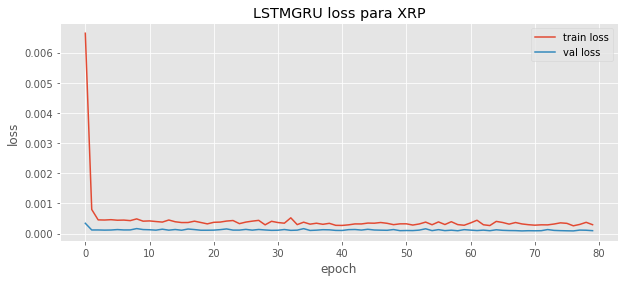

In [334]:
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title(model + ' loss para ' + cripto )
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [335]:
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.001,0.000294,0.000096


##### Predicciones sobre los datos de test y revertir la normalización

In [336]:
y_pred_test = regresor.predict(x_test)

y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

18/18 [==============================] - 2s 4ms/step


##### Comparación de las predicciones y los datos de test

In [337]:
datacompare = pd.DataFrame()
datatest=np.array(dataset['Close'][totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

,Data Test,Prediction Results
0,0.529976,0.550855
1,0.565898,0.552616
2,0.514649,0.577188
3,0.547167,0.552130
4,0.571915,0.558701
...,...,...
554,0.337303,0.360701
555,0.335478,0.353247
556,0.323496,0.347996
557,0.333087,0.338781


##### Cálculo de las métricas de evaluación

In [338]:
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :',rmse(datatest, datapred))

def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred)), 4)
    
print('Result Mean Absolute Error Prediction Model : ', mae(datatest, datapred))

Result Root Mean Square Error Prediction Model : 0.4681
Result Mean Absolute Error Prediction Model :  0.3736


##### Comparación gráfica de las predicciones y los datos de test

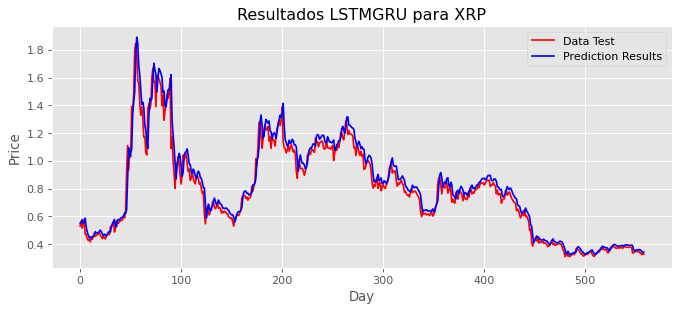

In [339]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Resultados ' + model + ' para ' + cripto)
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()